Problem 1

In [1]:
#import what we need for the job...
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Visualization
from IPython.display import display

In [2]:
!wget https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt

--2021-04-20 02:15:24--  https://www.cs.mtsu.edu/~jphillips/courses/CSCI4850-5850/public/PandP_Jane_Austen.txt
Resolving www.cs.mtsu.edu (www.cs.mtsu.edu)... 161.45.162.100
Connecting to www.cs.mtsu.edu (www.cs.mtsu.edu)|161.45.162.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683838 (668K) [text/plain]
Saving to: ‘PandP_Jane_Austen.txt.3’

PandP_Jane_Austen.t 100%[===================>] 667.81K  --.-KB/s    in 0.01s   

2021-04-20 02:15:24 (63.3 MB/s) - ‘PandP_Jane_Austen.txt.3’ saved [683838/683838]



In [3]:
!head PandP_Jane_Austen.txt

It is a truth universally acknowledged, that a single man in possession
of a good fortune, must be in want of a wife.

However little known the feelings or views of such a man may be on his
first entering a neighbourhood, this truth is so well fixed in the minds
of the surrounding families, that he is considered the rightful property
of some one or other of their daughters.

"My dear Mr. Bennet," said his lady to him one day, "have you heard that
Netherfield Park is let at last?"


In [4]:
# Preprocessing - grab lines from the file
with open('PandP_Jane_Austen.txt','r',encoding='utf-8')as f:
    lines=f.read().split('\n')
    # Paragraphs are separated by blank
    # lines -> just drop those lines...
text=[]
for i in range(len(lines)):
    if lines[i] != '':
        text=text+[lines[i]]
min_length=max([len(i) for i in text])
# Visual Confirmation that we have loaded the text in...
text[0:8]

['It is a truth universally acknowledged, that a single man in possession',
 'of a good fortune, must be in want of a wife.',
 'However little known the feelings or views of such a man may be on his',
 'first entering a neighbourhood, this truth is so well fixed in the minds',
 'of the surrounding families, that he is considered the rightful property',
 'of some one or other of their daughters.',
 '"My dear Mr. Bennet," said his lady to him one day, "have you heard that',
 'Netherfield Park is let at last?"']

In [5]:
!head unique_chars.txt

!
"
'
(
)
*
,
-
.
1


In [6]:
# Unique characters - precalculated
with open('unique_chars.txt','r',encoding='utf-8') as f:
    lines=f.read().split('\n')
lines=[line for line in lines if line !='']
# Integer code to symbol
itos=['','',' ']
for i in lines:
    itos=itos+[i]
# Symbol to integer code
stoi=dict()
stoi['STOP']=0
stoi['START']=1
for i in range(2,len(itos)):
    stoi[itos[i]]=i

In [7]:
# Total number of sentences
len(text)

10658

In [8]:
# Longest sentence - plus start/stop
max(len(i) for i in text)+2

76

In [9]:
# Number of tokens (each will be one-hot encoded)
len(itos)

71

In [10]:
def encode_seq(x,mapping,min_length=0):
    # String to one-hot
    y=[mapping['START']]
    for i in list(x):
        y=y+[mapping[i]]
    y=y+[mapping['STOP']]
        # Stop-padding - handled elsewhere...
    while len(y)<min_length:
        y=y+[mapping['STOP']]
    return keras.utils.to_categorical(y,len(mapping))

def decode_seq(x,mapping):
    # One-hot to string
    y=[]
    for i in x:
        y=y+[mapping[np.argmax(i)]]
    return ''.join(y)

In [11]:
# An encoding-decoding cycle on the first line...
temp= encode_seq(text[0],stoi)
temp = decode_seq(temp,itos)
temp

'It is a truth universally acknowledged, that a single man in possession'

In [12]:
# What was the first line in its original form?
text[0]

'It is a truth universally acknowledged, that a single man in possession'

In [13]:
dataX=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:]=temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:]=temp

In [14]:
X=dataX[0:dataX.shape[0]-1,:,:]
Y=dataY[1:dataY.shape[0],:,:]
preY=Y[:,0:Y.shape[1]-1,:]
postY=Y[:,1:Y.shape[1],:]

In [15]:
nlines=50
X=X[0:nlines,:,:]
Y=Y[0:nlines,:,:]
preY=preY[0:nlines,:,:]
postY=postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 76, 71)
(50, 76, 71)
(50, 75, 71)
(50, 75, 71)


In [16]:
# Size of the gestalt, context representations...
hidden_size=500
## Encoder Construction
# Make the layers
encoder_input=keras.layers.Input(shape=(None,X.shape[2]))
encoder_hidden=keras.layers.LSTM(hidden_size,return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output,enc_state_h,enc_state_c=encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states=[enc_state_h,enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input=keras.layers.Input(shape=(None,preY.shape[2]))
decoder_hidden=keras.layers.LSTM(hidden_size,
                                 return_sequences=True,
                                 return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output,decoder_state_h,decoder_state_c=decoder_hidden(
    decoder_input,initial_state=encoder_states)
decoder_dense=keras.layers.Dense(postY.shape[2],activation='softmax')
# Connect output to hidden
decoder_output=decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model=keras.Model([encoder_input,decoder_input],decoder_output)
# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500), (None, 1144000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 500),  1144000     input_2[0][0]                    
                                                                 lstm[0][1]                   

In [17]:
batch_size = nlines
epochs = 1000
history = model.fit([X,preY], postY,
                   batch_size = batch_size,
                   epochs=epochs,
                   verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


2/2 [==============================] - 4s 634ms/step - loss: 1.1428 - categorical_accuracy: 0.7443
Accuracy: 74.42666888237 %


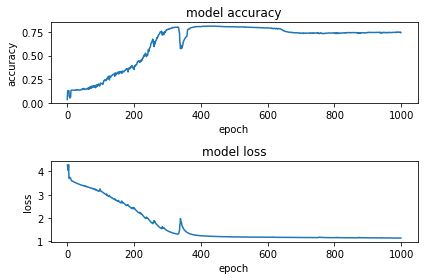

In [18]:
plt.figure(1)
#summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [19]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input,encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c=decoder_hidden(
    decoder_input,initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]
# Connect output to hidden(s)
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model(
    [decoder_input]+decoder_states_input,
    [decoder_output]+decoder_states)

In [20]:
# Get the gestalt context for the input sequence(s)
i=0
context=encoder_model.predict(X[i:i+1,:,:])
token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [21]:
# What should we see?
print('Input:',text[i])
print('Output:',text[i+1])

Input: It is a truth universally acknowledged, that a single man in possession
Output: of a good fortune, must be in want of a wife.


In [22]:
# Complete max cycles with the decoder
result=np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c=decoder_model.predict([token]+context)
    token=np.round(out)
    context=[h,c]
    result[:,x,:]=token
decode_seq(result[0,:,:],itos)

'of a good fortune, must be in want of a wife.'

In [23]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context=encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: "y tar Mr. Bennet," said his lady to him one day, "have you heard that
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net:  sternenda hesur in ali be rour oos h pady a ha
Txt: of the surrounding families, that he is considered the rightful property
Net: o oe on our tour fou thi daaty to kne of ch is inllat he  in e
Txt: of some one or other of their daughters.
Net: o on o o on o if i land Iatawe he sre oo  autat.ind 
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: "y tar Mr. Bennet," said his lady to him one day, "have you heard that
Txt: Netherfield Park is let at last?"
Net: o an the oenith ie land an wae  ofe sar  eelber, orisne h
Txt: Mr. Bennet replied that he had not.
Net: " er oned anti e that fo thin wore   he hat inett
Txt: "But it 

In [24]:
#get the gestalt context for the input sequence(s)
i = 0
context=encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context = [h,c]
        result[:,x,:]= token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context=encoder_model.predict(result)

Txt: of a good fortune, must be in want of a wife.
Net: of a good fortune, must be in want of a wife.
Txt: However little known the feelings or views of such a man may be on his
Net: " tha his deainn be theind oh ta  outh ored ther ih ha au y aten
Txt: first entering a neighbourhood, this truth is so well fixed in the minds
Net: o o on oo hat in  fome in wat ae oe
Txt: of the surrounding families, that he is considered the rightful property
Net: " tha his asin othei ouset ing foreig hin wfre piesthe
Txt: of some one or other of their daughters.
Net:  son one or oone fo e ary, I a se."
Txt: "My dear Mr. Bennet," said his lady to him one day, "have you heard that
Net: " th ire doug insely, nnsesrry ou esson fomenii o uo
Txt: Netherfield Park is let at last?"
Net:  o no or on i am an at ae int of an on beayuo to ayyurh
Txt: Mr. Bennet replied that he had not.
Net:  ther e tea bethfn semerill o  olibe tou  hes
Txt: "But it is," returned she; "for Mrs. Long has just been here, and she
Net: 

Problem 2

In [26]:
# Preprocessing - grab word from the file simplying by using white space
with open('PandP_Jane_Austen.txt','r',encoding='utf-8')as f:
    lines=f.read().split()
text=[]
for i in range(len(lines)):
    if lines[i] != '':
        text=text+[lines[i]]
min_length=max([len(i) for i in text])
# Visual Confirmation that we have loaded the text in...
text[0:8]

['It', 'is', 'a', 'truth', 'universally', 'acknowledged,', 'that', 'a']

In [27]:
dataX=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataX[i,0:len(temp),:]=temp
# Not strictly necessary, but I was trying some alternative strategies
# earlier and this is worth keeping around...
# This will be the same as dataX using this implementation...
dataY=np.ones([len(text),max([len(i)for i in text])+2,len(itos)])*(1.0/len(itos))
for i in range(len(text)):
    temp=encode_seq(text[i],stoi)
    dataY[i,0:len(temp),:]=temp

In [28]:
X=dataX[0:dataX.shape[0]-1,:,:]
Y=dataY[1:dataY.shape[0],:,:]
preY=Y[:,0:Y.shape[1]-1,:]
postY=Y[:,1:Y.shape[1],:]

In [29]:
nlines=500
X=X[0:nlines,:,:]
Y=Y[0:nlines,:,:]
preY=preY[0:nlines,:,:]
postY=postY[0:nlines,:,:]
print(X.shape)
print(Y.shape)
print(preY.shape)
print(postY.shape)

(50, 30, 71)
(50, 30, 71)
(50, 29, 71)
(50, 29, 71)


In [30]:
# Size of the gestalt, context representations...
hidden_size=500
## Encoder Construction
# Make the layers
encoder_input=keras.layers.Input(shape=(None,X.shape[2]))
encoder_hidden=keras.layers.LSTM(hidden_size,return_state=True)
# Tie the hidden layer to the input layer (passed in) 
encoder_output,enc_state_h,enc_state_c=encoder_hidden(encoder_input)
# We discard `encoder_outputs` and only keep the states.
encoder_states=[enc_state_h,enc_state_c]
## Decoder Construction
# Set up the decoder, using `encoder_states` as initial state.
decoder_input=keras.layers.Input(shape=(None,preY.shape[2]))
decoder_hidden=keras.layers.LSTM(hidden_size,
                                 return_sequences=True,
                                 return_state=True)
# Connect hidden to input (also reads from the encoder...)
decoder_hidden_output,decoder_state_h,decoder_state_c=decoder_hidden(
    decoder_input,initial_state=encoder_states)
decoder_dense=keras.layers.Dense(postY.shape[2],activation='softmax')
# Connect output to hidden
decoder_output=decoder_dense(decoder_hidden_output)
# Our functional API model now has -two- input layers:
# 1. Reads from X
# 2. Reads from preY
# and has a -single- output layer...
# 1. Targets are postY
model=keras.Model([encoder_input,decoder_input],decoder_output)
# Compile it...
model.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None, 71)]   0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 500), (None, 1144000     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 500),  1144000     input_6[0][0]                    
                                                                 lstm_2[0][1]               

In [31]:
batch_size = 10
epochs = 1000
history = model.fit([X,preY], postY,
                   batch_size = batch_size,
                   epochs=epochs,
                   verbose=0)
print('Accuracy:',model.evaluate([X,preY],postY)[1]*100.0,'%')


2/2 [==============================] - 3s 207ms/step - loss: 3.5192 - categorical_accuracy: 0.2028
Accuracy: 20.275862514972687 %


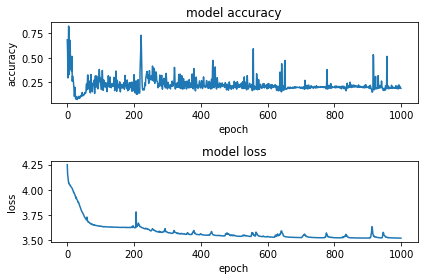

In [32]:
plt.figure(1)
#summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()
plt.show()

In [33]:
# Part 1 - make the encoder
# Make just a model out of the encoder
# input = encoder_input (Input layer)
# output = encoder_states (enc Hidden layer * 2)
encoder_model=keras.Model(encoder_input,encoder_states)
# Part 2 - make the decoder
# Make just a model out of the decoder
# input = encoder_states (enc Hidden layer * 2)
# output = decoder_output
decoder_state_input_h=keras.layers.Input(shape=(hidden_size,))
decoder_state_input_c=keras.layers.Input(shape=(hidden_size,))
# Connect hidden to input(s)
decoder_states_input=[decoder_state_input_h,decoder_state_input_c]
decoder_hidden_output,decoder_state_h,decoder_state_c=decoder_hidden(
    decoder_input,initial_state=decoder_states_input)
decoder_states=[decoder_state_h,decoder_state_c]
# Connect output to hidden(s)
decoder_output=decoder_dense(decoder_hidden_output)
decoder_model=keras.Model(
    [decoder_input]+decoder_states_input,
    [decoder_output]+decoder_states)

In [34]:
# Get the gestalt context for the input sequence(s)
i=0
context=encoder_model.predict(X[i:i+1,:,:])
token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
token

array([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [35]:
# What should we see?
print('Input:',text[i])
print('Output:',text[i+1])

Input: It
Output: is


In [36]:
# Complete max cycles with the decoder
result=np.zeros([1,postY.shape[1],postY.shape[2]])
for x in range(postY.shape[1]):
    out,h,c=decoder_model.predict([token]+context)
    token=np.round(out)
    context=[h,c]
    result[:,x,:]=token
decode_seq(result[0,:,:],itos)

'is'

In [37]:
# Iterate - teacher forcing through each line
for i in range(0,nlines):
    # Get the gestalt context for the input sequence(s)
    context=encoder_model.predict(X[i:i+1,:,:])
    # Prep a starting token...
    token=encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result=np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context=[h,c]
        result[:,x,:]=token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))

Txt: is
Net: is
Txt: a
Net: a
Txt: truth
Net: ingle
Txt: universally
Net: is
Txt: acknowledged,
Net: acknowledged,
Txt: that
Net: that
Txt: a
Net: a
Txt: single
Net: ingle
Txt: man
Net: man
Txt: in
Net: in
Txt: possession
Net: ot
Txt: of
Net: of
Txt: a
Net: a
Txt: good
Net: ingle
Txt: fortune,
Net: fortune,
Txt: must
Net: must
Txt: be
Net: be
Txt: in
Net: in
Txt: want
Net: ot
Txt: of
Net: of
Txt: a
Net: a
Txt: wife.
Net: ingle
Txt: However
Net: However
Txt: little
Net: little
Txt: known
Net: known
Txt: the
Net: the
Txt: feelings
Net: eelings
Txt: or
Net: or
Txt: views
Net: views
Txt: of
Net: of
Txt: such
Net: a
Txt: a
Net: a
Txt: man
Net: ingle
Txt: may
Net: in
Txt: be
Net: be
Txt: on
Net: in
Txt: his
Net: his
Txt: first
Net: first
Txt: entering
Net: entering
Txt: a
Net: a
Txt: neighbourhood,
Net: ingle
Txt: this
Net: this
Txt: truth
Net: truth
Txt: is
Net: is
Txt: so
Net: a
Txt: well
Net: well
Txt: fixed
Net: fixed
Txt: in
Net: in
Txt: the
Net: ot
Txt: minds
Net: eelings


In [38]:
#get the gestalt context for the input sequence(s)
i = 0
context=encoder_model.predict(X[i:i+1,:,:])
for i in range(0,nlines):
    token = encode_seq('',stoi)[0].reshape(1,1,len(stoi))
    result = np.zeros([1,postY.shape[1],postY.shape[2]])
    for x in range(postY.shape[1]):
        out,h,c=decoder_model.predict([token]+context)
        token=np.round(out)
        context = [h,c]
        result[:,x,:]= token
    print('Txt:',text[i+1])
    print('Net:',decode_seq(result[0,:,:],itos))
    # CRUCIAL -> keep predicted result instead of teacher forcing!
    context=encoder_model.predict(result)

Txt: is
Net: is
Txt: a
Net: a
Txt: truth
Net: th
Txt: universally
Net: a
Txt: acknowledged,
Net: th
Txt: that
Net: a
Txt: a
Net: th
Txt: single
Net: a
Txt: man
Net: th
Txt: in
Net: a
Txt: possession
Net: th
Txt: of
Net: a
Txt: a
Net: th
Txt: good
Net: a
Txt: fortune,
Net: th
Txt: must
Net: a
Txt: be
Net: th
Txt: in
Net: a
Txt: want
Net: th
Txt: of
Net: a
Txt: a
Net: th
Txt: wife.
Net: a
Txt: However
Net: th
Txt: little
Net: a
Txt: known
Net: th
Txt: the
Net: a
Txt: feelings
Net: th
Txt: or
Net: a
Txt: views
Net: th
Txt: of
Net: a
Txt: such
Net: th
Txt: a
Net: a
Txt: man
Net: th
Txt: may
Net: a
Txt: be
Net: th
Txt: on
Net: a
Txt: his
Net: th
Txt: first
Net: a
Txt: entering
Net: th
Txt: a
Net: a
Txt: neighbourhood,
Net: th
Txt: this
Net: a
Txt: truth
Net: th
Txt: is
Net: a
Txt: so
Net: th
Txt: well
Net: a
Txt: fixed
Net: th
Txt: in
Net: a
Txt: the
Net: th
Txt: minds
Net: a
